In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import IPython as IPy
import sklearn as skl
import mglearn as mgl
from sklearn.model_selection import train_test_split

import os
import tarfile
import urllib

import joblib

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

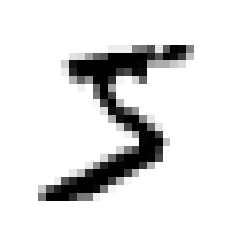

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

In [11]:
y = y.astype(np.uint8)

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

#Our model is good, but you know, the task wasn't that hard...

array([0.91125, 0.90855, 0.90915])

In [67]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [21]:
#Confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [22]:
#Precision - percentage of right five-identifications to all five-identifications
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
#Recall - percentage of right five-identifications to all fives
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [41]:
#F1 - combination of precision and recall (mean harmonic)
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [42]:
#Threshold - the bound between neg and pos predictions
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [43]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [44]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [82]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

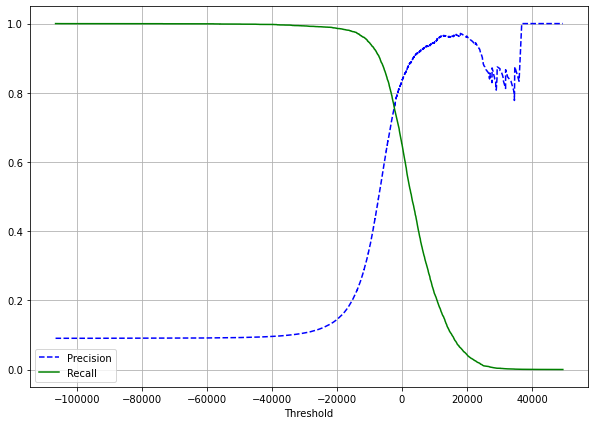

In [84]:
#Which treshold to use? 
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig = plt.figure(figsize=(10, 7))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = 'best')
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [46]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

In [47]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [48]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [49]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [59]:
#The ROC curve (reciever operating characteristics): Recall against (1 - Specificity) 
#Specificity = right_negatives / all_negatives (recall for negatives)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

No handles with labels found to put in legend.


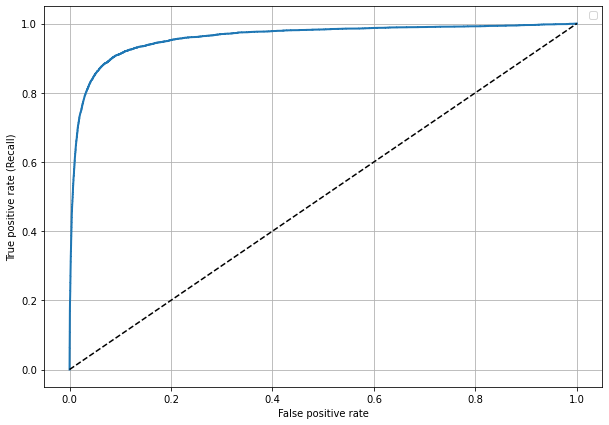

In [86]:
def plot_roc_curve(fpr, tpr, label = None):
    fig = plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylabel("True positive rate (Recall)")
    plt.xlabel("False positive rate")
    plt.legend(loc = 'best')
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [62]:
#Computing the area (integral)
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [63]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [66]:
y_probas_forest #A chance of each element of the data to belong to each class (neg and pos in our case)

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [68]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

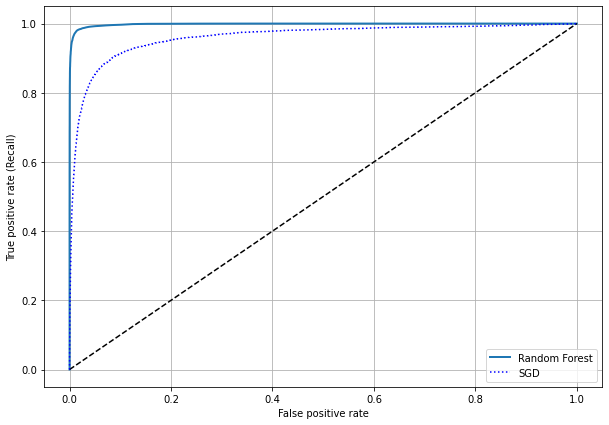

In [88]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "b:", label="SGD")
plt.legend(loc="lower right")
plt.show()

In [70]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

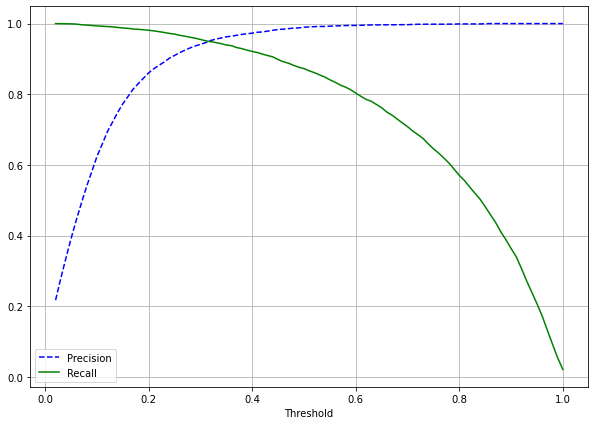

In [89]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)
plt.show()

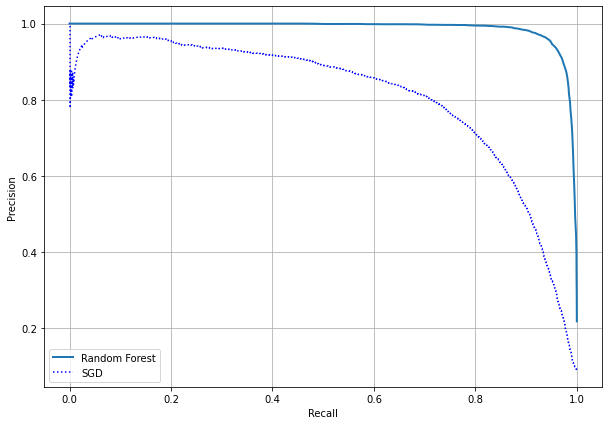

In [94]:
def plot_prec_vs_recall(precision, recall, label = None):
    fig = plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, linewidth = 2, label = label)
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc = 'best')
    plt.grid()
    
plot_prec_vs_recall(precisions_forest, recalls_forest, label = "Random Forest")
plt.plot(recalls, precisions, "b:", label="SGD")
plt.legend(loc="lower left")
plt.show()

In [95]:
threshold_99_precision = thresholds_forest[np.argmax(precisions_forest >= 0.99)]
threshold_99_precision

0.51

In [100]:
y_train_pred_99 = (y_scores_forest >= threshold_99_precision)

precision_score(y_train_5, y_train_pred_99)

0.9905083315756169

In [102]:
recall_score(y_train_5, y_train_pred_99)

0.8662608374838591

In [103]:
#Applying OneVsOne classifier
sgd_clf.fit(X_train, y_train) #This takes a hella long time ngl (around 2 minutes)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [104]:
 sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [105]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") #Let's have a tea...

array([0.87365, 0.85835, 0.8689 ])

In [106]:
#Perform simple scale and...
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") #...wait

array([0.8983, 0.891 , 0.9018])

In [107]:
#Fixing errors using confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

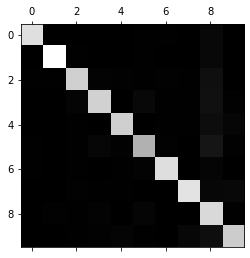

In [108]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [109]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

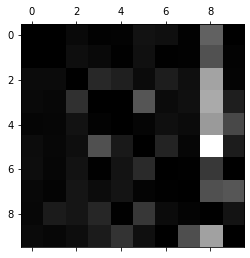

In [110]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#Eights are often being a misclassification

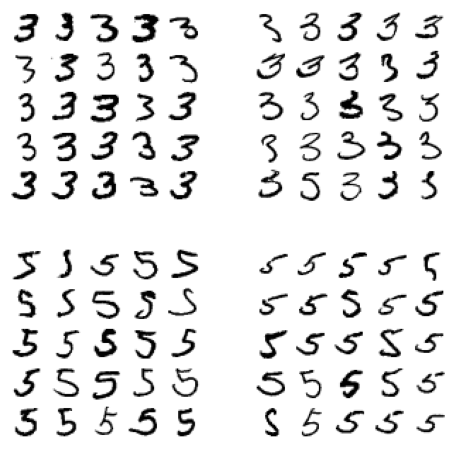

In [113]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()